In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, glob, os, random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 20 positions version

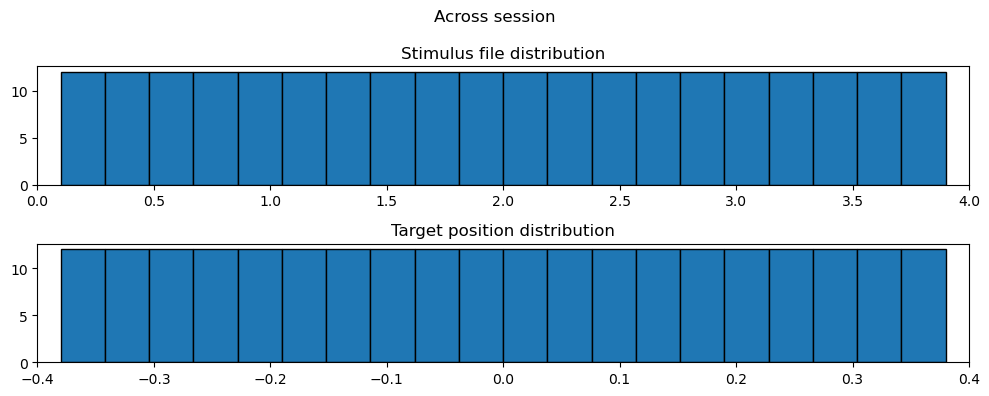

In [10]:
trial_info, trial_key, blockN = [], 0, 0

for run in [1,2]:

    for div in [0, -.2, .2]:
        
        blockN += 1

        # 1. sample 40 positions based on divider
        if div == 0:
            stim_pos_ls = np.round( np.sort( np.tile( np.arange(.1, 4.0, .2), 2 ) ), 1)
            
        elif div == -.2:
            stim_pos_ls = np.round( np.sort( np.tile( np.concatenate( [ np.arange(.1, 1.0, .2), np.arange(.1, 1.0, .2), np.arange(1.1, 3.0, .2) ] ), 2 ) ), 1)

        elif div == .2:
            stim_pos_ls = np.round( np.sort( np.tile( np.concatenate([ np.arange(1.1, 3.0, .2), np.arange(3.1, 4.0, .2), np.arange(3.1, 4.0, .2) ] ), 2 ) ), 1)

        # 2. sample noise, reversing order across runs
        noise_pos_ls = [0.0, 4.0] * 20 if run == 1 else [4.0, 0.0] * 20

        # 3. sample valence display order, reversing order across runs
        # valence_disp_ls = ['pen_rew', 'rew_pen'] * 20 if run == 1 else ['rew_pen', 'pen_rew'] * 20
        valence_disp_ls = ['pen_rew', 'rew_pen'] * 10 + ['rew_pen', 'pen_rew'] * 10

        for i in range(len(stim_pos_ls)):
            
            # set some vars outside the loop
            stim_pos_temp = (stim_pos_ls[i] - 2) * .2
            target_pos = stim_pos_temp if valence_disp_ls[i] == 'pen_rew' else -stim_pos_temp # reverse order

            anchor = random.uniform(-.4,.4)
            while abs(target_pos-anchor) < .1 or abs(target_pos-anchor) > .3:
            # if anchor is too close or far from target, resample. CONSIDER TOGGLING ANCHOR BETWEEN 2 VALUES.
                anchor = random.uniform(-.4,.4)

            img_prefix = 'input_data/stims/Shape_'

            # reminder: stim_pos (0,4) & target (-4,4)
            trial_info.append({
                    'blockN': blockN,
                    'run': run,
                    'div': div,
                    'trial_key': trial_key,

                    'stim_pos': stim_pos_ls[i],
                    'noise_pos': noise_pos_ls[i],
                    'val_C0F1': 'pen' if stim_pos_temp <= div else 'rew',
                    'val_C1F0': 'rew' if stim_pos_temp <= div else 'pen',
                    'valence_disp': valence_disp_ls[i],

                    'target_pos': target_pos,
                    'target_file': f'{img_prefix}{stim_pos_ls[i]}0_{noise_pos_ls[i]}0.png',
                    'disp_div': div if valence_disp_ls[i] == 'pen_rew' else -div, # reverse order
                    'anchor': anchor,

                    'img1_file': f'{img_prefix}0.00_{noise_pos_ls[i]}0.png' if valence_disp_ls[i] == 'pen_rew'\
                            else f'{img_prefix}4.00_{noise_pos_ls[i]}0.png',
                    'img2_file': f'{img_prefix}4.00_{noise_pos_ls[i]}0.png' if valence_disp_ls[i] == 'pen_rew'\
                            else f'{img_prefix}0.00_{noise_pos_ls[i]}0.png'
                    })
            
            trial_key += 1

            
df = pd.DataFrame(trial_info)
# if file doesnt exist, then create
df.to_csv('../input_data/trials.csv', index=False)

# across-session plot
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
fig.suptitle('Across session')

ax = axs[0]
ax.hist(df['stim_pos'], bins=20, edgecolor='black')
ax.set_title('Stimulus file distribution')
ax.set_xlim(.0, 4)

ax = axs[1]
ax.hist(df['target_pos'], bins=20, edgecolor='black')
ax.set_title('Target position distribution')
ax.set_xlim(-.4, .4)

plt.tight_layout()
plt.show()


## noise-free or noised plot by divider

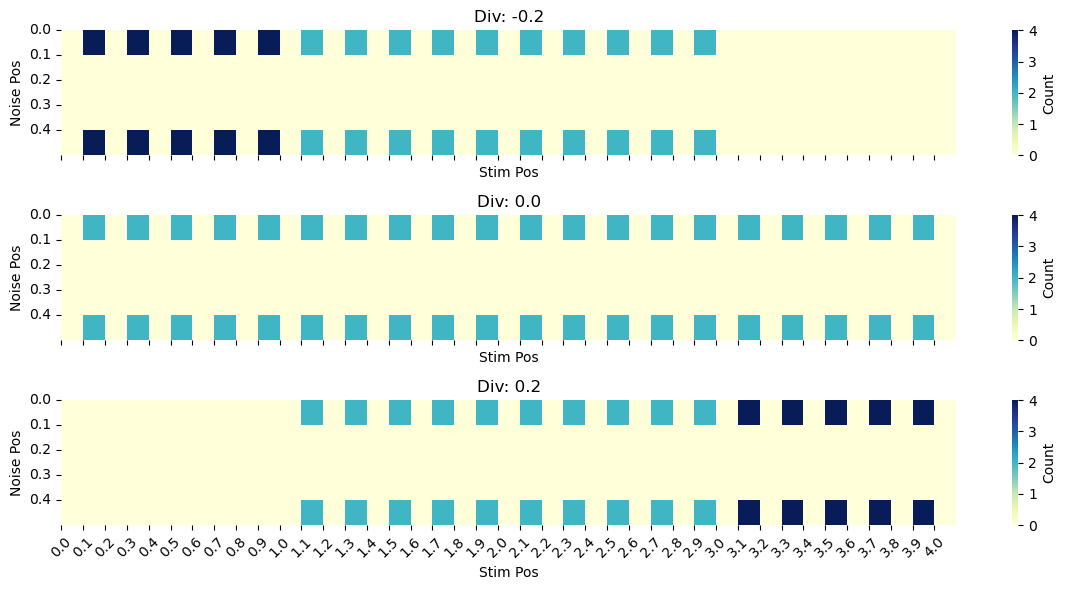

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)

# loop through dividers
for j, div in enumerate([-.2, .0, .2]):
    
    df_run_div = df[df['div'] == div]
    ax = axs[j]

    # 1. plot noised version

    heatmap_data = np.zeros((5, 41))        
    heatmap_data = np.zeros((5, 41))        
    for _, trial in df_run_div.iterrows():
        heatmap_data[int(trial['noise_pos']), int(10*trial['stim_pos'])] += 1

    sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax, 
                vmin=0, vmax=4, # 2 or 4
                cbar_kws={
                    'label': 'Count',
                    'ticks': [0, 1, 2, 3, 4] # [0, 1, 2] or [0, 1, 2, 3, 4]
                })
    
    ax.set_title(f'Div: {div}')
    ax.set_xlabel('Stim Pos')
    ax.set_ylabel('Noise Pos')
    
    noise_ticks = np.arange(0, 5, 1)
    ax.set_yticks(noise_ticks)
    ax.set_yticklabels([str(i/10) for i in noise_ticks])
    ax.tick_params(axis='y', labelrotation=0)

    stim_ticks = np.arange(0, 41, 1)
    ax.set_xticks(stim_ticks)
    ax.set_xticklabels([str(i/10) for i in stim_ticks])
    ax.tick_params(axis='x', labelrotation=45)

    # 2. plot noise-less version

    # # sns.histplot(df_run_div['stim_pos'], bins=41, binrange=(-.4, .4), ax=ax)
    # sns.histplot(df_run_div['target'], bins=41, binrange=(-.4, .4), ax=ax)
    # ax.set_title(f'run: {run}, div: {div}')
    # ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()


## plot each block

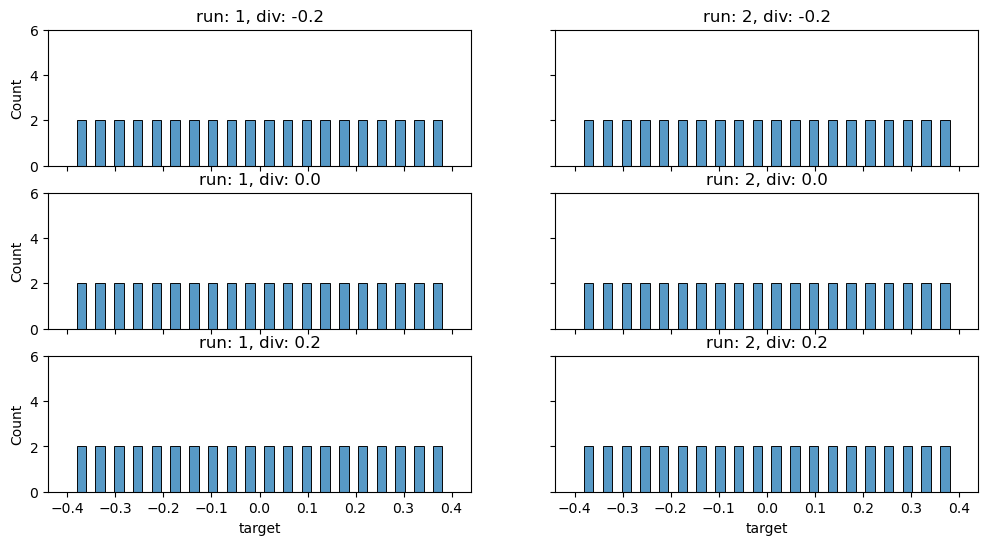

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

# loop through runs & dividers
for i, run in enumerate([1, 2]):
    for j, div in enumerate([-.2, .0, .2]):
        
        df_run_div = df[(df['run'] == run) & (df['div'] == div)]
        ax = axs[j, i]


        # 1. plot noised version

        # heatmap_data = np.zeros((5, 41))        
        # for _, trial in df_run_div.iterrows():
        #     heatmap_data[int(trial['noise_pos']), int(trial['stim_pos'])] += 1

        # sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax, 
        #             vmin=0, vmax=2,
        #             cbar_kws={
        #                 'label': 'Count',
        #                 'ticks': [0, 1, 2]
        #             })
        
        # ax.set_title(f'Run: {run}, Div: {div}')
        # ax.set_xlabel('Stim Pos')
        # ax.set_ylabel('Noise Pos')
        
        # noise_ticks = np.arange(.5, 5, 1)
        # ax.set_yticks(noise_ticks)
        # ax.set_yticklabels([str(i) for i in noise_ticks])
        # ax.tick_params(axis='y', labelrotation=0)

        # 2. plot noise-less version

        # sns.histplot(df_run_div['stim_disp_pos'], bins=41, binrange=(-.4, .4), ax=ax)
        sns.histplot(df_run_div['target'], bins=41, binrange=(-.4, .4), ax=ax)
        ax.set_title(f'run: {run}, div: {div}')
        ax.set_ylim(0, 6)

## histogram of trial-ease

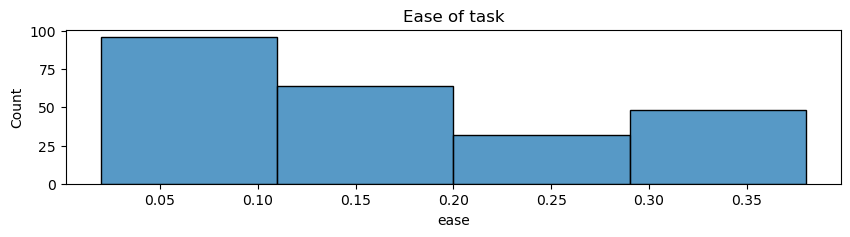

Proportion of trials where ease <= .1: 0.3333333333333333
valence
rew    120
pen    120
Name: count, dtype: int64
valence_disp
rew_pen    120
pen_rew    120
Name: count, dtype: int64


In [26]:
df['ease'] = abs(df['target_pos'] - df['disp_div'])
plt.figure(figsize=(10, 2))
sns.histplot(df['ease'], bins=4)
plt.title('Ease of task')
plt.show()

print(f"Proportion of trials where ease <= .1: {len(df[df['ease'] <= .1]) / len(df)}")
print(df['valence'].value_counts())
print(df['valence_disp'].value_counts())